# Career and Skills Intelligence Recommendation System
## Notebook 01 — Data Understanding

### Dataset Architecture (Revised)

| Dataset | Role |
|---|---|
| O\*NET Occupation Data | 894-occupation career backbone |
| O\*NET Skills | 35 standardised skill scores per occupation |
| O\*NET Job Zones | Education level - occupation mapping |
| O\*NET Education & Training | Required education per occupation |
| BLS Employment Projections | Demand level + AI risk per career (102 roles) |
| LinkedIn Job Postings | Real job market signals (skills, industries, salaries) |
| edX Courses | 975 courses for learning paths |
| Udemy Courses | 3,678 courses for learning paths |
| Coursera Courses | 3,404 courses — quality signal |
| Coursera Reviews |  Sentiment data for quality scoring |
| CBC Pathways |  Kenya CBC track-to-career mapping (kept) |



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
from pathlib import Path

warnings.filterwarnings('ignore')
sys.path.append(str(Path.cwd()))
from src.data_utils import DatasetSpec, inspect_dataset, resolve_dataset_file

DATA_DIR = Path('DATA')

DATASETS = {
    'onet_occupations':  DatasetSpec(name='O*NET Occupations',          base_name='new/Occupation Data',                    file_type='xlsx'),
    'onet_skills':       DatasetSpec(name='O*NET Skills',               base_name='new/Skills',                             file_type='xlsx'),
    'onet_job_zones':    DatasetSpec(name='O*NET Job Zones',            base_name='new/Job Zones',                          file_type='xlsx'),
    'onet_education':    DatasetSpec(name='O*NET Education & Training', base_name='new/Education, Training, and Experience', file_type='xlsx'),
    'bls_projections':   DatasetSpec(name='BLS Employment Projections', base_name='new/bls_employment_projections', file_type='csv'),
    'linkedin_postings': DatasetSpec(name='LinkedIn Job Postings',      base_name='new/postings', file_type='csv', read_kwargs={'low_memory': False}),
    'edx':               DatasetSpec(name='edX Courses',                base_name='new/edx_courses',    file_type='csv'),
    'udemy':             DatasetSpec(name='Udemy Courses',              base_name='new/udemy_courses',   file_type='csv'),
    'coursera':          DatasetSpec(name='Coursera Courses',           base_name='new/Coursera',        file_type='csv'),
    'coursera_reviews':  DatasetSpec(name='Coursera Reviews',           base_name='new/reviews',         file_type='csv'),
    'cbc_pathways':      DatasetSpec(name='CBC Pathways (Kenya)',        base_name='new/cbc_pathways',    file_type='csv'),
}

# Verify files
resolution_log = []
for key, spec in DATASETS.items():
    try:
        p = resolve_dataset_file(DATA_DIR, spec.base_name)
        resolution_log.append({'key': key, 'file': p.name, 'size_mb': round(p.stat().st_size/1024**2,2), 'status': 'FOUND'})
    except FileNotFoundError:
        resolution_log.append({'key': key, 'file': '—', 'size_mb': 0, 'status': 'NOT FOUND'})
pd.DataFrame(resolution_log).set_index('key')

,file,size_mb,status
key,,,
onet_occupations,Occupation Data.xlsx,0.10,FOUND
onet_skills,Skills.xlsx,3.25,FOUND
onet_job_zones,Job Zones.xlsx,0.04,FOUND
onet_education,"Education, Training, and Experience.xlsx",1.94,FOUND
bls_projections,bls_employment_projections.csv,0.01,FOUND
linkedin_postings,postings.csv,492.90,FOUND
edx,edx_courses.csv,1.89,FOUND
udemy,udemy_courses.csv,0.67,FOUND
coursera,Coursera.csv,1.28,FOUND


## 2.0 — O\*NET Occupation Data (894 occupations)

In [2]:
out = inspect_dataset(DATA_DIR, DATASETS['onet_occupations'])
onet_occ = out['df']
display(out['summary'])
print(f'Unique occupations : {onet_occ["title"].nunique()}')
display(onet_occ.sample(10, random_state=42)[['o*net-soc_code', 'title']].reset_index(drop=True))

,dataset,rows,cols,duplicates,missing_cells,memory_mb
0,O*NET Occupations,1016,3,0,0,0.415


Unique occupations : 1016


,o*net-soc_code,title
0,47-4041.00,Hazardous Materials Removal Workers
1,31-9093.00,Medical Equipment Preparers
2,19-1022.00,Microbiologists
3,53-1043.00,First-Line Supervisors of Material-Moving Mach...
4,51-9061.00,"Inspectors, Testers, Sorters, Samplers, and We..."
5,33-2022.00,Forest Fire Inspectors and Prevention Specialists
6,49-9061.00,Camera and Photographic Equipment Repairers
7,17-3027.00,Mechanical Engineering Technologists and Techn...
8,19-1029.03,Geneticists
9,39-3012.00,Gambling and Sports Book Writers and Runners


## 3.0 — O\*NET Skills (35 standardised skill dimensions)

,dataset,rows,cols,duplicates,missing_cells,memory_mb
0,O*NET Skills,62580,15,0,31290,41.177


Unique skills  : 35
Unique occs    : 894
Score range    : 0.00 — 6.00


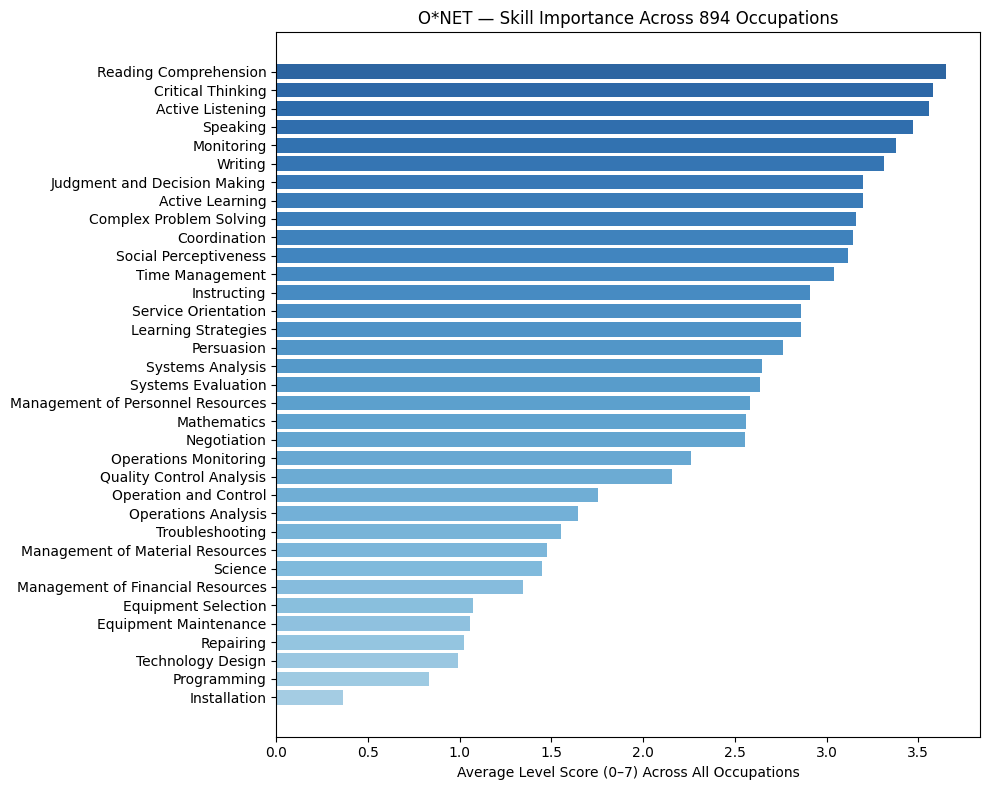

,o*net-soc_code,title,element_name,scale_name
0,25-4011.00,Archivists,Complex Problem Solving,Level
1,31-1131.00,Nursing Assistants,Social Perceptiveness,Importance
2,31-1133.00,Psychiatric Aides,Technology Design,Level
3,17-3025.00,Environmental Engineering Technologists and Te...,Instructing,Importance
4,51-4194.00,"Tool Grinders, Filers, and Sharpeners",Negotiation,Level
5,47-5022.00,Excavating and Loading Machine and Dragline Op...,Technology Design,Importance
6,17-3027.01,Automotive Engineering Technicians,Science,Level
7,39-9031.00,Exercise Trainers and Group Fitness Instructors,Learning Strategies,Importance
8,35-1011.00,Chefs and Head Cooks,Time Management,Importance
9,51-8031.00,Water and Wastewater Treatment Plant and Syste...,Quality Control Analysis,Importance


In [3]:
out = inspect_dataset(DATA_DIR, DATASETS['onet_skills'])
onet_skills = out['df']
display(out['summary'])

# Use Level scores only
level_scores = onet_skills[onet_skills['scale_id'] == 'LV']
print(f'Unique skills  : {level_scores["element_name"].nunique()}')
print(f'Unique occs    : {level_scores["title"].nunique()}')
print(f'Score range    : {level_scores["data_value"].min():.2f} — {level_scores["data_value"].max():.2f}')

# Average skill importance across all occupations
avg_skill = level_scores.groupby('element_name')['data_value'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(avg_skill)))
ax.barh(avg_skill.index[::-1], avg_skill.values[::-1], color=colors, alpha=0.85)
ax.set_xlabel('Average Level Score (0–7) Across All Occupations')
ax.set_title('O*NET — Skill Importance Across 894 Occupations')
plt.tight_layout(); plt.savefig('models/onet_skill_importance.png', dpi=150); plt.show()

display(onet_skills.sample(10, random_state=42)[['o*net-soc_code', 'title','element_name','scale_name']].reset_index(drop=True))

## 4.0 — O\*NET Job Zones (Education ↔ Occupation Mapping)

,dataset,rows,cols,duplicates,missing_cells,memory_mb
0,O*NET Job Zones,923,5,0,0,0.258


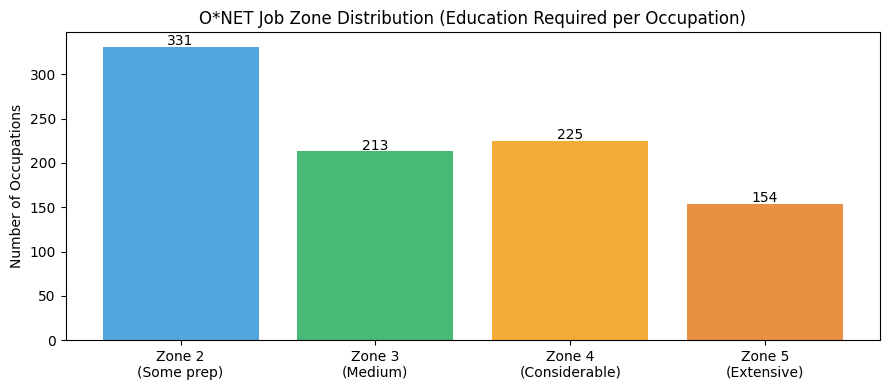


Job Zone → User Type Mapping:
  Zone 1–2 → CBC / 8-4-4 High School students
  Zone 3   → TVET / Diploma holders
  Zone 4   → Graduates (Bachelor's degree)
  Zone 5   → Postgraduates / Professionals


,o*net-soc_code,title,job_zone
0,25-2058.00,"Special Education Teachers, Secondary School",4
1,51-9192.00,"Cleaning, Washing, and Metal Pickling Equipmen...",2
2,11-9031.00,"Education and Childcare Administrators, Presch...",4
3,51-8099.01,Biofuels Processing Technicians,2
4,25-1066.00,"Psychology Teachers, Postsecondary",5
5,13-1041.01,Environmental Compliance Inspectors,4
6,19-2031.00,Chemists,4
7,17-2151.00,"Mining and Geological Engineers, Including Min...",4
8,39-5012.00,"Hairdressers, Hairstylists, and Cosmetologists",3
9,53-1042.01,Recycling Coordinators,2


In [4]:
out = inspect_dataset(DATA_DIR, DATASETS['onet_job_zones'])
onet_jz = out['df']
display(out['summary'])

jz_dist = onet_jz['job_zone'].value_counts().sort_index()
jz_labels = {1:'Zone 1\n(Little prep)', 2:'Zone 2\n(Some prep)', 3:'Zone 3\n(Medium)',
             4:'Zone 4\n(Considerable)', 5:'Zone 5\n(Extensive)'}

fig, ax = plt.subplots(figsize=(9, 4))
bars = ax.bar([jz_labels.get(z, str(z)) for z in jz_dist.index], jz_dist.values,
              color=['#3498db','#27ae60','#f39c12','#e67e22','#e74c3c'], alpha=0.85)
ax.set_title('O*NET Job Zone Distribution (Education Required per Occupation)')
ax.set_ylabel('Number of Occupations')
for bar, val in zip(bars, jz_dist.values):
    ax.text(bar.get_x() + bar.get_width()/2, val+2, str(val), ha='center', fontsize=10)
plt.tight_layout(); plt.show()

print('\nJob Zone → User Type Mapping:')
print('  Zone 1–2 → CBC / 8-4-4 High School students')
print('  Zone 3   → TVET / Diploma holders')
print('  Zone 4   → Graduates (Bachelor\'s degree)')
print('  Zone 5   → Postgraduates / Professionals')

display(onet_jz.sample(10, random_state=42)[['o*net-soc_code', 'title', 'job_zone']].reset_index(drop=True))

## 5.0 — O\*NET Education & Training Requirements

In [5]:
out = inspect_dataset(DATA_DIR, DATASETS['onet_education'])
onet_edu = out['df']
display(out['summary'])

edu_req = onet_edu[onet_edu['element_name'] == 'Required Level of Education']
print(f'Occupations with education data : {edu_req["title"].nunique()}')
top_edu = edu_req.groupby('category')['data_value'].mean().sort_values(ascending=False)
display(top_edu.head(10).reset_index().rename(columns={'data_value': 'avg_importance'}))

display(onet_edu.sample(10, random_state=42)[['o*net-soc_code', 'title', 'element_name']].reset_index(drop=True))

,dataset,rows,cols,duplicates,missing_cells,memory_mb
0,O*NET Education & Training,37125,15,0,57925,24.422


Occupations with education data : 878


,category,avg_importance
0,2.0,27.831298
1,6.0,20.494453
2,3.0,9.304260
3,8.0,8.421913
4,5.0,7.917483
5,1.0,7.841629
6,4.0,6.602563
7,11.0,5.806891
8,12.0,2.691241
9,7.0,1.736253


,o*net-soc_code,title,element_name
0,51-9071.00,Jewelers and Precious Stone and Metal Workers,Related Work Experience
1,51-4121.00,"Welders, Cutters, Solderers, and Brazers",On-Site or In-Plant Training
2,49-3053.00,Outdoor Power Equipment and Other Small Engine...,On-Site or In-Plant Training
3,53-4011.00,Locomotive Engineers,Required Level of Education
4,33-3021.06,Intelligence Analysts,On-Site or In-Plant Training
5,11-3051.04,Biomass Power Plant Managers,Related Work Experience
6,53-5011.00,Sailors and Marine Oilers,Required Level of Education
7,51-3023.00,Slaughterers and Meat Packers,Required Level of Education
8,53-1043.00,First-Line Supervisors of Material-Moving Mach...,Required Level of Education
9,23-1021.00,"Administrative Law Judges, Adjudicators, and H...",Required Level of Education


## 6.0 — BLS Employment Projections (Demand + AI Risk)

,dataset,rows,cols,duplicates,missing_cells,memory_mb
0,BLS Employment Projections,102,12,0,0,0.033


,occupation,career_family,employment_2022,employment_2032,change_number,change_pct,openings_annual,median_wage_2022,growth_category,demand_level,automation_risk,demand_score
0,Software Engineer,Technology,1795.3,1926.5,131.2,25.7,162.9,127260,Much faster than average,High,0.04,0.757075
1,Data Scientist,Technology,199.1,243.7,44.6,35.3,23.0,103500,Much faster than average,High,0.02,0.983491
2,Data Analyst,Technology,177.8,218.4,40.6,36.0,19.4,82900,Much faster than average,High,0.03,1.000000
3,Machine Learning Engineer,Technology,159.4,206.8,47.4,35.5,17.8,136620,Much faster than average,High,0.02,0.988208
4,Web Developer,Technology,190.3,207.5,17.2,16.0,26.5,78580,Faster than average,High,0.06,0.528302



Career families covered:


,career_family,count
0,Business And Finance,18
1,Technology,17
2,Engineering,17
3,Healthcare,17
4,Arts And Media,8
5,Education,6
6,Law And Public Service,6
7,Transport And Aviation,4
8,Agriculture,3
9,Policy And Research,2


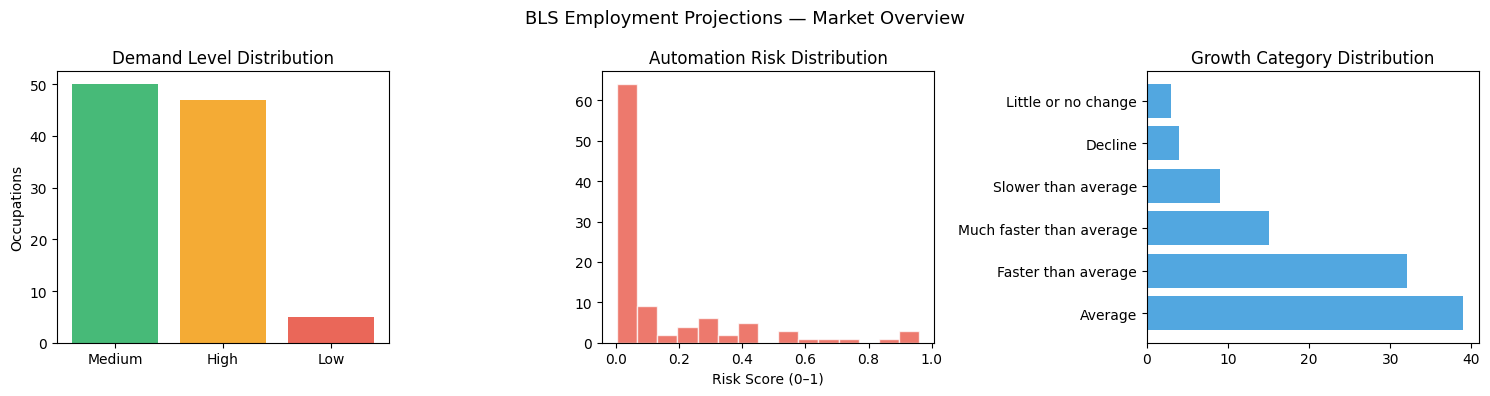


=== Most Future-Proof Careers ===


,occupation,career_family,automation_risk,demand_level,change_pct,median_wage_2022
50,Veterinarian,Healthcare,0.004,High,14.7,119100
40,Dentist,Healthcare,0.004,High,13.1,163220
35,Medical Doctor,Healthcare,0.004,High,9.0,229300
41,Surgeon,Healthcare,0.004,High,7.1,229300
38,Psychologist,Healthcare,0.005,High,13.1,85330
44,Allied Health Professional,Healthcare,0.010,High,20.2,61710
46,Dietitian,Healthcare,0.010,High,15.6,66450
47,Optometrist,Healthcare,0.010,High,14.0,125590
74,Professor,Education,0.010,High,10.3,80840
42,Radiologist,Healthcare,0.010,High,9.8,229300


In [6]:
out = inspect_dataset(DATA_DIR, DATASETS['bls_projections'])
bls_df = out['df']
display(out['summary'])
display(bls_df.head(5))

print('\nCareer families covered:')
display(bls_df['career_family'].value_counts().reset_index())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

demand_counts = bls_df['demand_level'].value_counts()
axes[0].bar(demand_counts.index, demand_counts.values,
            color=['#27ae60','#f39c12','#e74c3c'], alpha=0.85)
axes[0].set_title('Demand Level Distribution'); axes[0].set_ylabel('Occupations')

axes[1].hist(bls_df['automation_risk'], bins=15, color='#e74c3c', alpha=0.75, edgecolor='white')
axes[1].set_title('Automation Risk Distribution'); axes[1].set_xlabel('Risk Score (0–1)')

growth_counts = bls_df['growth_category'].value_counts()
axes[2].barh(growth_counts.index, growth_counts.values, color='#3498db', alpha=0.85)
axes[2].set_title('Growth Category Distribution')

plt.suptitle('BLS Employment Projections — Market Overview', fontsize=13)
plt.tight_layout(); plt.savefig('models/bls_market_overview.png', dpi=150, bbox_inches='tight'); plt.show()

print('\n=== Most Future-Proof Careers ===')
display(bls_df.sort_values(['automation_risk','demand_score'], ascending=[True,False]).head(15)
        [['occupation','career_family','automation_risk','demand_level','change_pct','median_wage_2022']])

## 7.0 — LinkedIn Job Postings (Real Market Signals)

> **Source:** https://www.kaggle.com/datasets/arshkon/linkedin-job-postings?select=postings.csv  
> Place file at `DATA/new/postings.csv`. This is a large file (500MB+) — a 50K row sample is used for EDA.

In [7]:
postings_path = DATA_DIR / 'new' / 'postings.csv'
postings_df = None

if postings_path.exists():
    postings_df = pd.read_csv(postings_path, low_memory=False, nrows=50000)
    print(f'Sample loaded  : {postings_df.shape}')
    print(f'Full file size : {round(postings_path.stat().st_size / 1024**3, 2)} GB')
    print(f'Columns        : {postings_df.columns.tolist()}')
    display(postings_df.head(3))
else:
    print('postings.csv not found in DATA/new/')
    print('Download: https://www.kaggle.com/datasets/arshkon/linkedin-job-postings')

Sample loaded  : (50000, 31)
Full file size : 0.48 GB
Columns        : ['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips']


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0


In [8]:
if postings_df is not None:
    print('=== Missingness Overview ===')
    miss = (postings_df.isnull().sum()/len(postings_df)*100).sort_values(ascending=False)
    display(miss[miss>0].reset_index().rename(columns={'index':'column', 0:'missing_%'}))

    key_fields = ['title','company_name','location','work_type',
                  'formatted_experience_level','remote_allowed','med_salary']
    print('\n=== Key Field Cardinality ===')
    for col in key_fields:
        if col in postings_df.columns:
            print(f'  {col:<35} {postings_df[col].nunique():>7,} unique')

=== Missingness Overview ===


,column,missing_%
0,closed_time,98.344
1,skills_desc,98.118
2,med_salary,94.700
3,remote_allowed,87.324
4,applies,77.144
5,max_salary,76.150
6,min_salary,76.150
7,currency,70.850
8,compensation_type,70.850
9,normalized_salary,70.850



=== Key Field Cardinality ===
  title                                31,046 unique
  company_name                         13,354 unique
  location                              5,713 unique
  work_type                                 7 unique
  formatted_experience_level                6 unique
  remote_allowed                            1 unique
  med_salary                              778 unique


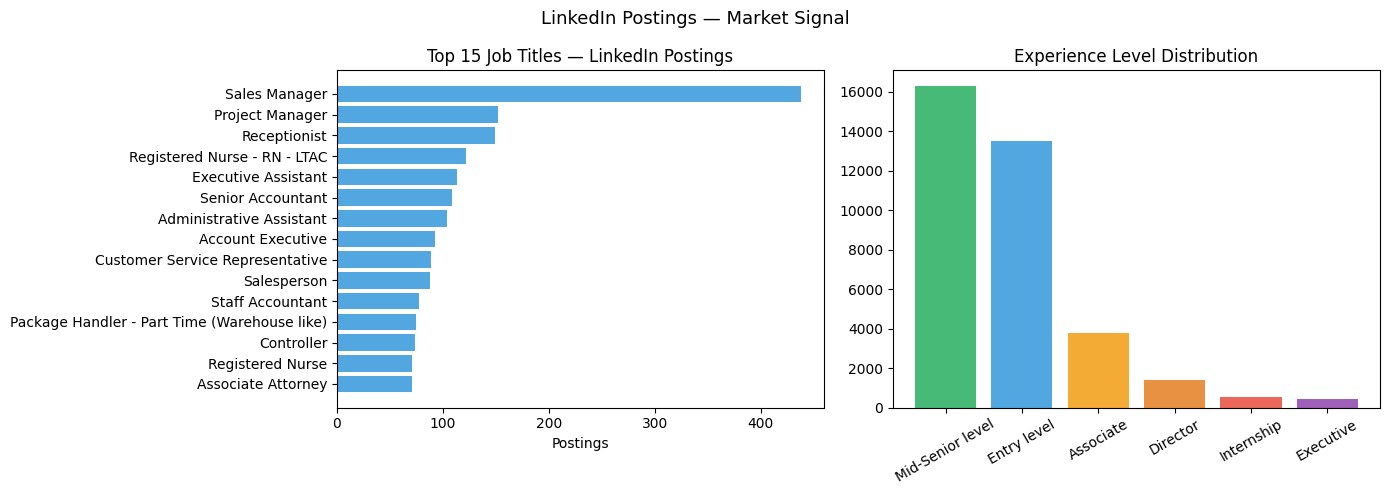

In [9]:
if postings_df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    if 'title' in postings_df.columns:
        top_t = postings_df['title'].value_counts().head(15)
        axes[0].barh(top_t.index[::-1], top_t.values[::-1], color='#3498db', alpha=0.85)
        axes[0].set_title('Top 15 Job Titles — LinkedIn Postings')
        axes[0].set_xlabel('Postings')

    if 'formatted_experience_level' in postings_df.columns:
        exp = postings_df['formatted_experience_level'].value_counts()
        axes[1].bar(exp.index, exp.values,
                    color=['#27ae60','#3498db','#f39c12','#e67e22','#e74c3c','#8e44ad'][:len(exp)], alpha=0.85)
        axes[1].set_title('Experience Level Distribution')
        axes[1].tick_params(axis='x', rotation=30)

    plt.suptitle('LinkedIn Postings — Market Signal', fontsize=13)
    plt.tight_layout(); plt.savefig('models/linkedin_overview.png', dpi=150, bbox_inches='tight'); plt.show()

## 8.0 — Course Datasets (edX + Udemy + Coursera)

In [10]:
out_edx   = inspect_dataset(DATA_DIR, DATASETS['edx']);   edx_df   = out_edx['df']
out_udemy = inspect_dataset(DATA_DIR, DATASETS['udemy']); udemy_df = out_udemy['df']
out_crs   = inspect_dataset(DATA_DIR, DATASETS['coursera']); crs_df = out_crs['df']
out_rev   = inspect_dataset(DATA_DIR, DATASETS['coursera_reviews']); rev_df = out_rev['df']

for name, df in [('edX', edx_df), ('Udemy', udemy_df), ('Coursera', crs_df), ('Reviews', rev_df)]:
    print(f'{name:<12}: {len(df):>6,} rows | {df.shape[1]} cols | {df.isnull().sum().sum():>6,} nulls')

total_courses = len(edx_df) + len(udemy_df) + len(crs_df)
print(f'\nTotal course catalogue: {total_courses:,} courses across 3 platforms')


edX         :    975 rows | 16 cols |    780 nulls
Udemy       :  3,678 rows | 12 cols |      0 nulls
Coursera    :  3,404 rows | 9 cols |      0 nulls
Reviews     : 107,018 rows | 3 cols |      0 nulls

Total course catalogue: 8,057 courses across 3 platforms


In [11]:
# CBC Pathways
out_cbc = inspect_dataset(DATA_DIR, DATASETS['cbc_pathways'])
cbc_df  = out_cbc['df']
display(out_cbc['summary'])
display(out_cbc['head'])

if 'pathway' in cbc_df.columns and 'track' in cbc_df.columns:
    display(cbc_df.groupby(['pathway','track']).size().reset_index(name='subject_combos'))

,dataset,rows,cols,duplicates,missing_cells,memory_mb
0,CBC Pathways (Kenya),535,5,0,0,0.205


,pathway,track,subjects,program_code,pathway_id
0,ARTS & SPORTS SCIENCE,ARTS,"Arabic,Fine Arts,Theatre & Film",AS1001,25211070-b138-4b82-813d-bbb7383a5c1d
1,ARTS & SPORTS SCIENCE,ARTS,"Biology,Fine Arts,Theatre & Film",AS1002,1cf6be29-e82d-4e59-ac5f-10d4c3da7a22
2,ARTS & SPORTS SCIENCE,ARTS,"Business Studies,Fine Arts,Theatre & Film",AS1003,84bc8e17-5fb0-4242-b23f-83141081fec4
3,ARTS & SPORTS SCIENCE,ARTS,"Computer Studies,Fine Arts,Theatre & Film",AS1004,d5d0a13e-fc32-4c57-8e59-65fc1b49fb97
4,ARTS & SPORTS SCIENCE,ARTS,"Christian Religious Education,Fine Arts,Theatr...",AS1005,21d1a140-fd7b-416b-822e-6846af18c3f3


,pathway,track,subject_combos
0,ARTS & SPORTS SCIENCE,ARTS,52
1,ARTS & SPORTS SCIENCE,SPORTS,30
2,SOCIAL SCIENCES,HUMANITIES & BUSINESS STUDIES,117
3,SOCIAL SCIENCES,LANGUAGES & LITERATURE,84
4,STEM,APPLIED SCIENCES,89
5,STEM,PURE SCIENCES,47
6,STEM,TECHNICAL STUDIES,116


## 9.0 — Data Quality Summary

In [12]:
loaded_dfs = {
    'O*NET Occupations':          onet_occ,
    'O*NET Skills':               onet_skills,
    'O*NET Job Zones':            onet_jz,
    'O*NET Education & Training': onet_edu,
    'BLS Projections':            bls_df,
    'edX Courses':                edx_df,
    'Udemy Courses':              udemy_df,
    'Coursera Courses':           crs_df,
    'Coursera Reviews':           rev_df,
    'CBC Pathways':               cbc_df,
}
if postings_df is not None:
    loaded_dfs['LinkedIn Postings (sample)'] = postings_df

rows = []
for name, df in loaded_dfs.items():
    miss_total = df.isnull().sum().sum()
    miss_pct   = miss_total / (len(df) * df.shape[1]) * 100
    rows.append({
        'Dataset':       name,
        'Rows':          f'{len(df):,}',
        'Cols':          df.shape[1],
        'Missing Cells': f'{miss_total:,}',
        'Missing %':     f'{miss_pct:.1f}%',
        'Duplicates':    f'{df.duplicated().sum():,}',
        'Status':        'Ready' if miss_pct < 30 else 'Needs cleaning'
    })
display(pd.DataFrame(rows))

,Dataset,Rows,Cols,Missing Cells,Missing %,Duplicates,Status
0,O*NET Occupations,"1,016",3,0,0.0%,0,Ready
1,O*NET Skills,"62,580",15,"31,290",3.3%,0,Ready
2,O*NET Job Zones,923,5,0,0.0%,0,Ready
3,O*NET Education & Training,"37,125",15,"57,925",10.4%,0,Ready
4,BLS Projections,102,12,0,0.0%,0,Ready
5,edX Courses,975,16,780,5.0%,1,Ready
6,Udemy Courses,"3,678",12,0,0.0%,6,Ready
7,Coursera Courses,"3,404",9,0,0.0%,0,Ready
8,Coursera Reviews,"107,018",3,0,0.0%,0,Ready
9,CBC Pathways,535,5,0,0.0%,0,Ready
